# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from dotenv import load_dotenv
from openai import OpenAI
import os
from tqdm.notebook import tqdm

# Data

In [3]:
df = pd.read_csv("amazon_reviews.csv")
df.shape

(4915, 12)

In [4]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


# Preprocess

we need to check if the reviewText is actually strings, this means, a valid text

In [5]:
df.dropna(subset=['reviewText'], inplace=True)
df.shape

(4914, 12)

# EDA

## Rating 

first, I'l investigate if there is some bias on rating. Because this will be important for the check on sentiment analysis, because we can expected a relation beteween sentiments and rating.

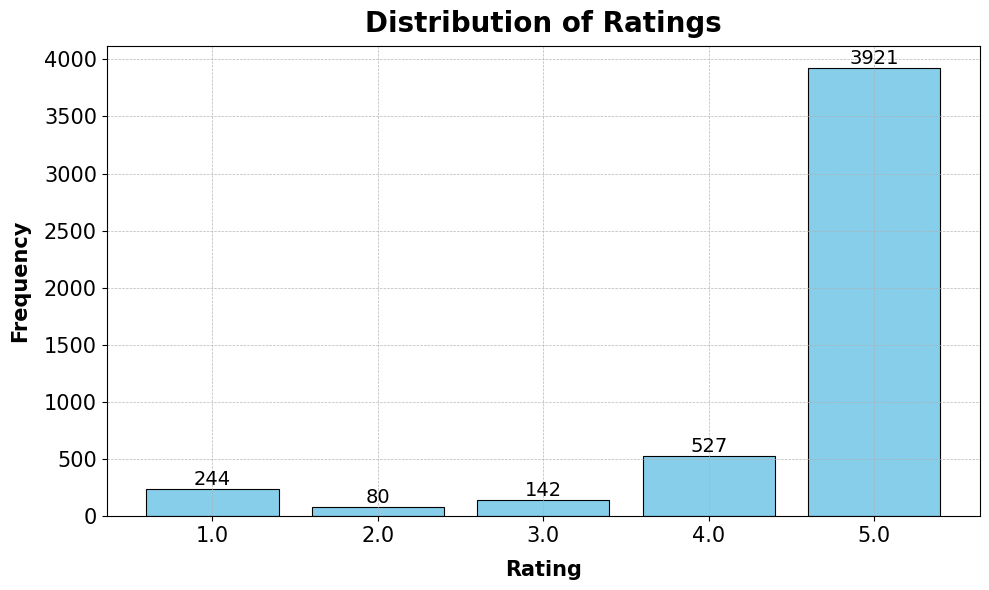

In [6]:
#first plot is to see if our dataset have a bias for a rate (overall)

rating_counts = df['overall'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
bars = plt.bar(rating_counts.index, rating_counts, color='skyblue', edgecolor='black', linewidth=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, int(yval), ha='center', va='bottom', fontsize=14)

plt.xlabel('Rating', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Distribution of Ratings', fontsize=20, pad=10, fontweight='bold')
plt.xticks(ticks=rating_counts.index, labels=rating_counts.index, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
plt.tight_layout()
plt.show()

# Trend

And import trend to considerar, is that people who give lower ratings are more likely to write comments and this comments tend to be longer.

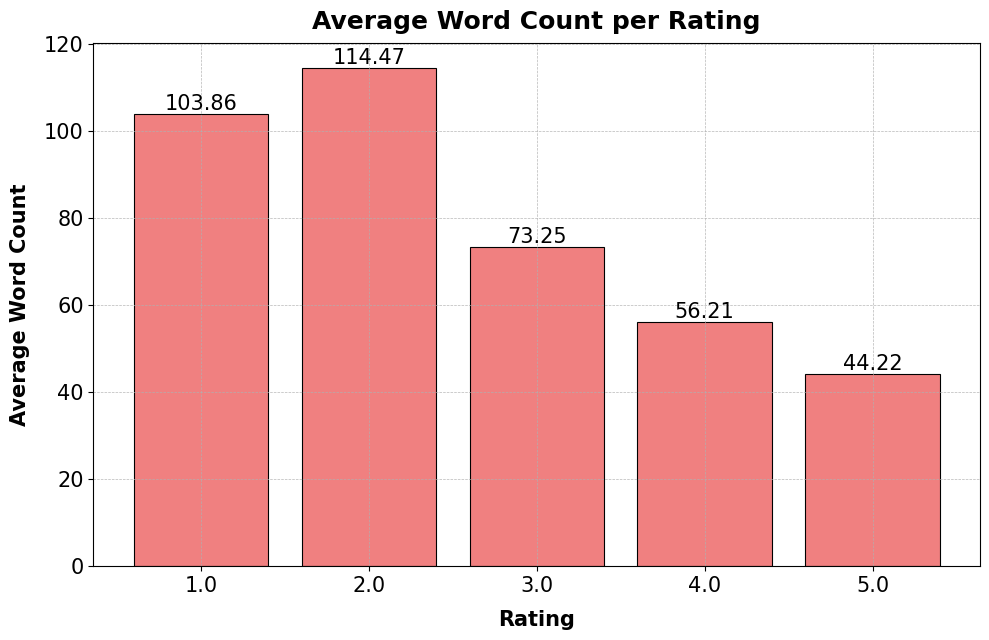

In [7]:
# Using split to calculate the number of words in each comment
df['Word Count'] = df['reviewText'].apply(lambda x: len(x.split()))

# Calculating the average word count per rating
average_word_count = df.groupby('overall')['Word Count'].mean()
average_word_count_df = average_word_count.reset_index()

# Plot to visualize the average word count per rating
plt.figure(figsize=(10, 6.5))
bars = plt.bar(average_word_count.index, average_word_count, color='lightcoral', edgecolor='black', linewidth=0.8)

# Adding text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=15)

plt.xlabel('Rating', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Average Word Count', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Average Word Count per Rating', fontsize=18, pad=10, fontweight='bold')
plt.xticks(ticks=average_word_count.index, labels=average_word_count_df['overall'], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
plt.tight_layout()
plt.show()

This confirmar our expectation: the lower ratings (1 to 2) has the higher number of average words, in the other hand, the higher rates, have the lower average count of words. This confirm that when the client is more satisfied, less is the chance to provide a long comment.

# Preprocess


In [8]:
def preprocess(text):
    """
    Preprocesses the given text by removing duplicate symbols and extra whitespaces.
    
    Args:
        text (str): The input text to be preprocessed.
    
    Returns:
        str: The preprocessed text.
    """
    # Remove duplicate symbols.
    text = re.sub(r'([^\w\s])\1+', r'\1', text)
    
    # Remove extra whitespaces.
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Check if the string length is 1, if so, return an empty string.
    if len(text) == 1:
        return ""
    return text

In [9]:
df['processed_comment'] = df['reviewText'].apply(preprocess) # Applying the preprocess function to each comment

# Sentiment Analysis

In [10]:
tqdm.pandas(desc="Processing sentiments") # Adds a progress bar when applying the lambda function

In [11]:
client = OpenAI(
    #load_dotenv()
    api_key=os.getenv('API_KEY'),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
)

In [12]:
def get_sentiment(text):
    try:
        completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a sentiment analysis assistant. Your task is to classify the sentiment of a given text as 'positive', 'negative', or 'neutral' based on its content."},
            {
                "role": "user",
                "content": f"The following text is feedback from a user answering the question: 'Do you have any feedback or suggestions?'. Please classify its sentiment as 'positive', 'negative', or 'neutral': '{text}'."
            }
        ]
    )
        match = re.search(r"negative|neutral|positive", completion.choices[0].message.content.strip(), re.IGNORECASE)
        if match:
            return match.group(0).lower()
        else:
            print(f"No valid sentiment found in response: {completion.choices[0].message.content.strip()}")
            return "undefined"
        
    except Exception as e:
        print(f"Error processing text: '{text}' | Exception: {e}")
        return "Error"

In [13]:
df['sentiment'] = df['processed_comment'].progress_apply(get_sentiment)

Processing sentiments:   0%|          | 0/4914 [00:00<?, ?it/s]

In [15]:
df.to_csv("sentiment_classified.csv")

In [ ]:
df = pd.read_csv("sentiment_classified")

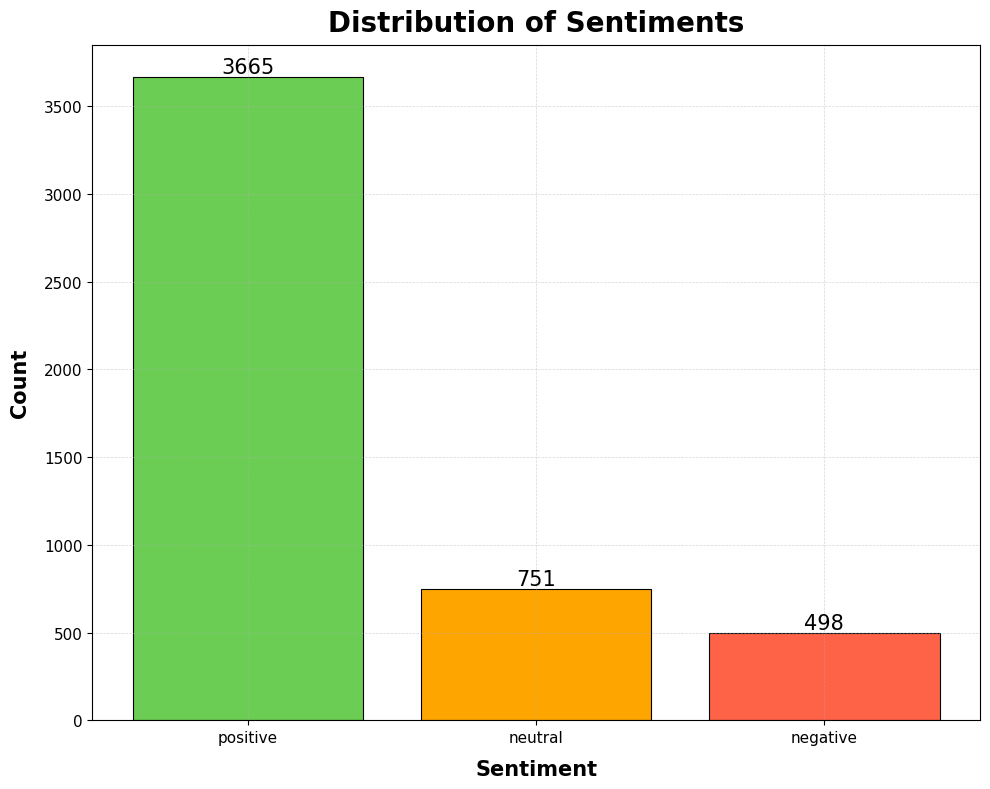

In [18]:
# Count of Manually Assigned Sentiments
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

plt.figure(figsize=(10, 8))
bars = plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'], color=['#6BCD53','orange', '#FF6347'],edgecolor='black', linewidth=0.8)

# Adding text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + -0.5, f'{yval:.0f}', ha='center', va='bottom', fontsize=15)

plt.xlabel('Sentiment', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Count', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Distribution of Sentiments', fontsize=20, pad=10, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = sentiment_counts.index.tolist()
sentiment_values = sentiment_counts.values.tolist()

In [20]:
sentiment_labels = ['positive', 'neutral', 'negative']

In [30]:
!pip3 install --upgrade nbformat

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Supondo que você já tenha os sentiment_counts, sentiment_labels e sentiment_values definidos

# Define cores para cada sentimento
colors = {'positive': '#6BCD53', 'neutral': 'orange', 'negative': '#FF6347'}

sorted_colors = [colors[label] for label in sentiment_labels]

# Cria o layout de subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'bar'}, {'type':'domain'}]])

# Adiciona o gráfico de barras com texto acima de cada barra
fig.add_trace(
    go.Bar(
        x=sentiment_labels, 
        y=sentiment_values, 
        marker_color=sorted_colors, 
        text=sentiment_values, 
        textposition='inside', 
        showlegend=False,
        hoverinfo='y',
        textfont=dict(size=18)
    ),
    row=1, col=1
)

# Adiciona o gráfico de pizza
fig.add_trace(
    go.Pie(
        labels=sentiment_labels, 
        values=sentiment_values, 
        hole=.4, 
        marker=dict(colors=sorted_colors), 
        hoverinfo='label+percent',
        textfont=dict(size=18)
    ),
    row=1, col=2
)

# Atualiza o layout com títulos e tamanho
fig.update_layout(
    title_text='Sentiment Distributions',
    title_x=0.5,  # Centraliza o título principal
    title_font=dict(size=24),  # Aumenta o tamanho do título principal
    annotations=[
        dict(text='Sentiment Count', x=0.05, y=1.1, xref='paper', yref='paper', showarrow=False, font=dict(size=20)),
        dict(text='Sentiment Percentage', x=0.99, y=1.1, xref='paper', yref='paper', showarrow=False, font=dict(size=20))
    ],
    width=1000,
    height=500
)

# Mostra o gráfico
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed